In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression


from xgboost import XGBRFClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

from feature_engine.encoding import OneHotEncoder
from sklearn.metrics import accuracy_score
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, OneHotEncoder, OrdinalEncoder, StandardScaler, MaxAbsScaler

from sklearn.model_selection import train_test_split
from sklearn import metrics


import warnings
warnings.filterwarnings("ignore")

# Criação do dataframe

In [2]:
df = pd.read_csv('DataFrame-Modelo.csv')
df = pd.DataFrame(df)
df.head()

,Unnamed: 0,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,Female,0,Yes,No,1,No,No,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,1,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,2,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,3,Male,0,No,No,45,No,No,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,4,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


# Separação das variáveis

In [3]:
X = df.drop(['Churn','Unnamed: 0'], axis=1)


y = df['Churn']

y = y.map({'No' : 0,
           'Yes' : 1})

In [4]:
X_test, X_train, y_test, y_train = train_test_split(X, y, test_size=0.3, random_state=42)

In [5]:
#Separação das features
features_categorical = [
    'gender',
    'SeniorCitizen',
    'Partner',
    'Dependents',
    'PhoneService',
    'MultipleLines',
    'InternetService',
    'OnlineSecurity',
    'OnlineBackup',
    'DeviceProtection',
    'TechSupport',
    'StreamingTV',
    'StreamingMovies',
    'Contract',
    'PaperlessBilling',
    'PaymentMethod',
    
]

features_numeric = [
    'tenure',
    'MonthlyCharges',
    'TotalCharges'
]

# Montagem do pipeline 

In [6]:


numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy='median')),
        ("scaler", StandardScaler())
    ]
)

categorical_transformer = Pipeline(
    steps = [
        ('imputer', SimpleImputer(strategy='constant')),
        ('encoder', ce.OneHotEncoder())
    ]
)

#Aplicando o tratamento dos pipelines

preprocessor = ColumnTransformer(
    transformers= [
        ('numeric', numeric_transformer, features_numeric),
        ('categorical', categorical_transformer, features_categorical)
    ]

)


#Pipeline do modelo
pipeline = Pipeline(
    steps=[('preprocessor', preprocessor),
           ('model', LogisticRegression(random_state=42, solver= "liblinear", multi_class="auto", n_jobs=-1, C=1 ) ),

      ]
)

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
print('===================================')
print(f' score: {round(pipeline.score(X_test, y_test),3)}')
print('===================================')
print(metrics.classification_report(y_test, y_pred))

 score: 0.799
              precision    recall  f1-score   support

           0       0.85      0.89      0.87      3635
           1       0.63      0.55      0.59      1295

    accuracy                           0.80      4930
   macro avg       0.74      0.72      0.73      4930
weighted avg       0.79      0.80      0.79      4930



# Avaliação do Modelo

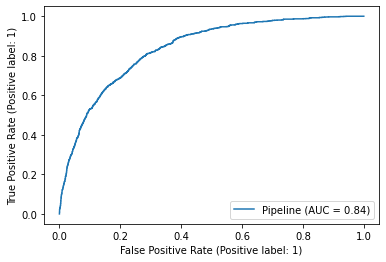

In [7]:
from sklearn.metrics import plot_roc_curve

plot_roc_curve(pipeline, X_test, y_test)

In [8]:
print('****Results****')
y_pred = pipeline.predict(X_test)
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
print("Precision:", metrics.precision_score(y_test, y_pred))
print("Recall:", metrics.recall_score(y_test, y_pred))

****Results****
Accuracy: 0.798580121703854
Precision: 0.6336283185840708
Recall: 0.5528957528957529


# Fazendo predições 

In [9]:
forecast = pd.DataFrame({'gender': 'female', 'SeniorCitizen': 1, 'Partner':'No', 'Dependents' : 'Yes', 'tenure': 10,
       'PhoneService' : 'No', 'MultipleLines': 'No', 'InternetService': 'DSL', 'OnlineSecurity' : 'No',
       'OnlineBackup' : 'Yes', 'DeviceProtection' : 'Yes', 'TechSupport' : 'No', 'StreamingTV' : 'No',
       'StreamingMovies': 'Yes', 'Contract' : 'One year', 'PaperlessBilling': 'No', 'PaymentMethod' : 'Electronic check' ,
       'MonthlyCharges' : 28.15, 'TotalCharges' : 108.15}, index=[0])
probability = pipeline.predict_proba(forecast)
print('Eu teria {}% de probabilidade abandonar a assinatura'\
      .format(round(probability[:,1][0]*100, 2)))

Eu teria 19.37% de probabilidade abandonar a assinatura
